In [1]:
#
# https://github.com/rawlings-group/paresto/blob/master/examples/green_book/bvsm_red.m
#

In [2]:
# Import libraries
from pyomo.environ import *
from pyomo.dae import *
import pyomo.contrib.parmest.parmest as parmest
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import scipy.stats as spstat
from scipy.stats import f
from pyomo.contrib.interior_point.inverse_reduced_hessian import inv_reduced_hessian_barrier

In [3]:
# load flow rate data
flow_data = pd.read_csv('flow_data.csv')
lc_data = pd.read_csv('lc_data.csv')
teaf      = 0.00721
teaden    = 0.728
cBf = teaf

In [4]:
tQf = np.insert(flow_data['t'].values, 0, 0)
Qf = np.insert(flow_data["Qf"].values / teaden, 0, 0)

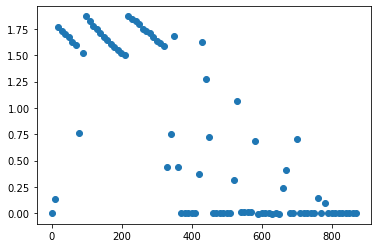

In [5]:
fig, ax = plt.subplots()
ax.scatter(tQf, Qf)

In [6]:
tlc = lc_data['t'].values
lc = lc_data['lc_meas'].values

In [7]:
Qf_if = interp1d(tQf, Qf, 'previous', bounds_error = False)
lc_if = interp1d(tlc, lc, 'previous', bounds_error = False)

In [19]:
#tout = np.unique(np.sort(np.concatenate((np.linspace(0.0, 869.0, num = 300), tQf, tlc))))
tout = np.unique(np.sort(np.concatenate((tQf, tlc))))
tout

array([  0,   9,  19,  29,  39,  49,  59,  69,  79,  89,  99, 109, 119,
       129, 139, 149, 159, 169, 179, 189, 199, 209, 219, 229, 239, 249,
       259, 269, 279, 289, 299, 309, 319, 329, 339, 349, 359, 369, 379,
       389, 399, 409, 414, 419, 424, 429, 434, 439, 444, 449, 459, 469,
       479, 489, 493, 499, 503, 509, 513, 519, 523, 529, 533, 539, 549,
       559, 569, 579, 582, 589, 592, 599, 602, 609, 612, 619, 621, 629,
       631, 639, 641, 649, 651, 659, 661, 669, 671, 679, 681, 689, 690,
       699, 700, 709, 710, 719, 720, 729, 730, 739, 740, 749, 750, 759,
       769, 779, 789, 799, 809, 819, 829, 839, 848, 849, 858, 859, 868,
       869])

In [20]:
data = [{'tout': tout, 'tlc': tlc, 'Qf_if': Qf_if, 'lc':lc, 'cBf': cBf}]

In [21]:
def bvsm_model(data):
    
    tout = data['tout']
    tlc = data['tlc']
    Qf_if = data['Qf_if']
    lc_m = data['lc']
    cBf = data['cBf']
    
    Vr0 = 2370
    
    m = ConcreteModel()
    
    m.k = Var(initialize = 2.0, bounds = (0, 10))
    m.nA0 = Var(initialize = 2.35, bounds = (2, 3))
    
    m.time = ContinuousSet(bounds = (0, max(tout)), initialize = tout)
    
#    m.Vr = Var(m.time)
#    m.reps2 = Var(m.time)
    m.Vr = Var(m.time, initialize = Vr0, bounds = (Vr0,None))
    m.reps2 = Var(m.time, initialize = 0)
    m.y = Var(m.time, initialize = 1e-6, bounds = (0, 1))
    
    m.Badded_v = Var(m.time, initialize = 0, bounds = (0, None))
    m.expr1_v = Var(m.time, initialize = 0)
    
    m.dVr = DerivativeVar(m.Vr)
    m.dreps2 = DerivativeVar(m.reps2)
    
    def _dVr_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            return m.dVr[t] == float(Qf_if(t))
    m.dVr_eq = Constraint(m.time, rule = _dVr_eq)
    
    def _calc_Badded(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            expr = m.Badded_v[t] == (m.Vr[t] - Vr0) * cBf
        return expr
    m.Badded_cons = Constraint(m.time, rule = _calc_Badded)
    
    def _calc_expr1(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            expr = m.expr1_v[t] * (m.Badded_v[t] - 2 * m.reps2[t] + 1e-6) == m.k * (m.nA0 - m.Badded_v[t] + m.reps2[t])
        return expr
    m.expr1_cons = Constraint(m.time, rule = _calc_expr1)
    
    def _dreps2_eq(m, t):
        if t == 0:
            return Constraint.Skip
        else:
#            Badded = (m.Vr[t] - Vr0) * cBf
#            expr1 = m.k * (m.nA0 - Badded + m.reps2[t]) / (Badded - 2 * m.reps2[t] + 1e-6)
#        return m.dreps2[t] == float(Qf_if(t)) * cBf / (1.0 + expr1)
            expr = m.dreps2[t] * (1.0 + m.expr1_v[t]) == float(Qf_if(t)) * cBf
        return expr
    m.dreps2_eq = Constraint(m.time, rule = _dreps2_eq)
    
    def _ycalc(m, t):
        if t == 0:
            return Constraint.Skip
        else:
            Badded = (m.Vr[t] - Vr0) * cBf
            nD = m.reps2[t]
            nC = Badded - 2 * nD
            return m.y[t] * (nC + 2 * nD) == nC 
    m.ycalc = Constraint(m.time, rule = _ycalc) 
    
#    def _initcon(m):
#        yield m.Vr[m.time.first()] == Vr0
#        yield m.reps2[m.time.first()] == 0.0
#    m.initcon = ConstraintList(rule = _initcon)

    def sse_obj_rule(m):
#        return sum((float(lc_if(t)) / m.y[t] - 1.0) ** 2 for t in tlc) 
        return sum((float(lc_if(t)) - m.y[t]) ** 2 for t in tlc) 
    m.sse_obj = Objective(rule=sse_obj_rule, sense = minimize)
    
    #disc = TransformationFactory('dae.collocation')
    #disc.apply_to(m, nfe=200, ncp=2)
    
    disc = TransformationFactory('dae.collocation')
    disc.apply_to(m, nfe=60, ncp = 1, scheme = 'LAGRANGE-RADAU')
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=300, scheme = 'BACKWARD')
    
    #disc = TransformationFactory('dae.finite_difference')
    #disc.apply_to(m, nfe=1, scheme = 'BACKWARD')
    
    for t in m.time:
        if t == 0:
            m.Vr[t].fix(Vr0)
            m.reps2[t].fix(0.0)
        else:
            m.Vr[t] = Vr0
            m.Vr[t].setlb(Vr0)
            m.reps2[t] = 0.0
    
    return m

In [22]:
m = bvsm_model(data[0])
#m.k.fix(8.0)
#m.nA0.fix(2.35)

    number of finite elements specified in apply. The larger number of finite
    elements will be used.


In [ ]:
### Declare all suffixes
# Ipopt bound multipliers (obtained from solution)
m.ipopt_zL_out = Suffix(direction=Suffix.IMPORT)
m.ipopt_zU_out = Suffix(direction=Suffix.IMPORT)
# Ipopt bound multipliers (sent to solver)
m.ipopt_zL_in = Suffix(direction=Suffix.EXPORT)
m.ipopt_zU_in = Suffix(direction=Suffix.EXPORT)
# Obtain dual solutions from first solve and send to warm start
m.dual = Suffix(direction=Suffix.IMPORT_EXPORT)


In [ ]:
solver = SolverFactory('ipopt')
solver.solve(m, tee = True)

In [ ]:
m.k.free()
m.nA0.free()
solver = SolverFactory('ipopt')

m.ipopt_zL_in.update(m.ipopt_zL_out)
m.ipopt_zU_in.update(m.ipopt_zU_out)
solver.options['warm_start_init_point'] = 'yes'
solver.options['warm_start_bound_push'] = 1e-6
solver.options['warm_start_mult_bound_push'] = 1e-6
solver.options['mu_init'] = 1e-6

In [23]:
#m = bvsm_model(data[0])
solver = SolverFactory('ipopt')
solver.solve(m, tee = True)

Ipopt 3.14.5: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     2221
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      738

Total number of variables............................:      821
                     variables with only lower bounds:      234
                variables with lower and upper bounds:      119
                     variables with only upper bounds:        0
Total number of equality constraints.................:      819
Total number of inequ

 156  4.0374678e-01 8.60e-02 1.13e+01  -1.7 5.68e+01    -  1.00e+00 1.00e+00h  1
 157  3.6123684e-01 1.58e-01 1.98e+01  -1.7 1.92e+02    -  1.00e+00 1.00e+00h  1
 158  3.6472994e-01 7.59e-03 4.42e-01  -1.7 2.88e+01    -  1.00e+00 1.00e+00h  1
 159  3.6486233e-01 1.41e-05 2.78e-03  -1.7 2.25e+00    -  1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160  1.0182524e-01 3.20e-02 2.01e+03  -3.8 9.81e+01    -  5.58e-01 1.00e+00f  1
 161  1.2279437e-02 5.61e-01 8.91e+02  -3.8 1.85e+02    -  5.52e-01 1.00e+00h  1
 162  1.6236727e-02 4.11e-01 1.89e+03  -3.8 6.00e+02    -  8.45e-02 1.65e-01H  1
 163  8.3080752e-03 1.19e-02 5.07e+03  -3.8 1.86e-01  -0.1 2.58e-04 1.00e+00h  1
 164  4.2919688e-03 3.16e-04 5.08e+04  -3.8 5.65e+00    -  1.00e+00 1.00e+00h  1
 165  7.0246457e-04 2.63e-03 2.14e+03  -3.8 5.11e+01    -  1.00e+00 1.00e+00h  1
 166  6.7558974e-04 2.30e-07 1.90e-04  -3.8 6.03e-04  -0.6 1.00e+00 1.00e+00h  1
 167  4.9923305e-04 1.50e-05

{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 819, 'Number of variables': 821, 'Sense': 'unknown'}], 'Solver': [{'Status': 'ok', 'Message': 'Ipopt 3.14.5\\x3a Optimal Solution Found', 'Termination condition': 'optimal', 'Id': 0, 'Error rc': 0, 'Time': 0.2541484832763672}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

In [ ]:
len(m.time._fe)

In [24]:
[m.k(), m.nA0()]

[2.6606531847457853, 2.344450373303213]

(0.0, 0.2)

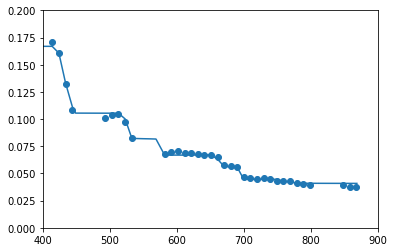

In [25]:
fig, ax = plt.subplots()
ax.plot(list(m.time), [m.y[t]() for t in m.time])
ax.scatter(data[0]['tlc'], data[0]['lc'])
ax.set_xlim(400, 900)
ax.set_ylim(0, 0.2)

In [26]:
solve_result, inv_red_hes = inv_reduced_hessian_barrier(m, 
                    independent_variables= [m.k, m.nA0],
                    tee=True)

Ipopt 3.14.5: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.5, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:     2221
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      738

Total number of variables............................:      821
                     variables with only lower bounds:      234
                variables with lower and upper bounds:      119
                     variables with only upper bounds:        0
Total number of equality constraints...

In [27]:
n = len(data[0]['tlc'])
p = 2
sse = m.sse_obj()
mult_factor = p * f.ppf(0.95, p, n-p)
f'sse:{sse}, mult_factor:{mult_factor}'

'sse:0.00012561003121462855, mult_factor:6.5698353020765765'

In [28]:
cov_est = 2 * sse / (n - p) * inv_red_hes
cov_est

array([[ 7.46776648e-03, -6.48115156e-05],
       [-6.48115156e-05,  1.16022761e-06]])

In [29]:
delta_param = np.sqrt(mult_factor * np.diag(cov_est))
delta_param

array([0.22149943, 0.00276089])